In [1]:
# if you realize you need a package that isn't installed, get it explicitly
# do not forget to update the environment.yml or requirements.txt file 
# when you push the updated file, it will trigger a rebuild of the image

!conda install -y more-itertools
# !conda env export > /home/environment.yml

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /miniconda/envs/ds-env:
#
more-itertools            3.2.0                    py27_0  


In [2]:
import os
import pandas as pd
from more_itertools import flatten

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.style.use('seaborn-white')
sns.set_context("talk")

rcParams['figure.figsize'] = 12, 5 
rcParams['font.family'] = 'Roboto'

font_title = {
    'size': 18, 
    'weight': "bold", 
    'name': 'Montserrat'
}

font_axes = {
    'size': 14, 
    'weight': "bold", 
    'name': 'Montserrat'
}

font_text = {
    'size': 14, 
    'weight': 400, 
    'name': 'Roboto'
}

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/miniconda/envs/ds-env/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['flatten']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
os.chdir("..")

PATH_ROOT = os.getcwd()
PATH_TO_FIGS = PATH_ROOT + '/reports/figures/'

In [4]:
from src.data.obtain import get_raw_data
from src.data.scrub import scrub_raw_data

In [5]:
if not os.path.exists('data/04-processed/titanic.csv'):
    print("Importing and scrubbing raw data.")
    df_raw = get_raw_data()
    df = scrub_raw_data(df_raw)
else:
    print("Retrieving cleaned data from backup.")
    df = pd.read_csv('data/04-processed/titanic.csv')

Retrieving cleaned data from backup.


## Explore

- Univariate (distributions)
- Bivariate (correlations)
- By-group analysis
- Feature Engineering
- Feature Selection

In [6]:
y = df['survived'].copy()

print("Average Survival Rate: {}%".format(y.mean().round(3) * 100))

Average Survival Rate: 38.2%


''

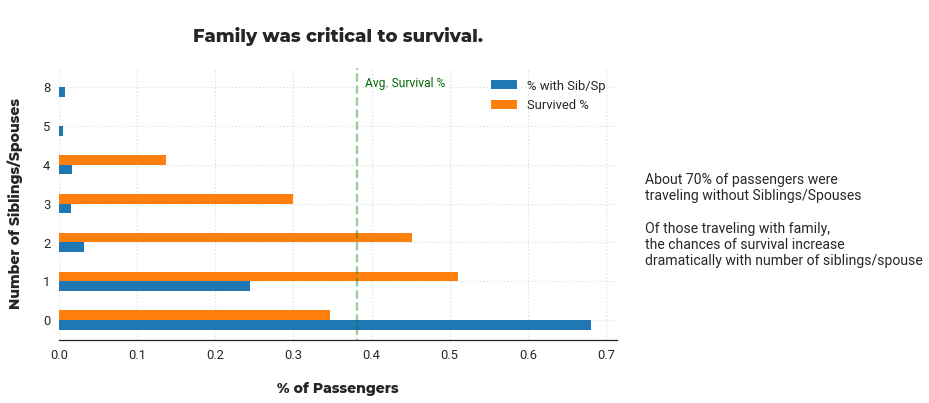

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

pd.DataFrame({
    'Survived %': df.groupby('sibsp').apply(lambda g: g.loc[:, 'survived'].mean()),
    '% with Sib/Sp': df['sibsp'].value_counts(normalize=True)
}).plot.barh(ax=ax)

ax.set_title("\nFamily was critical to survival.\n", fontdict=font_title);
ax.set_xlabel("\n% of Passengers", fontdict=font_axes)
ax.set_ylabel("Number of Siblings/Spouses\n", fontdict=font_axes)

ax.vlines(y.mean(), -1, 9, color='green', linestyle='dashed', alpha=0.4)
ax.annotate(s="Avg. Survival %", xy=(y.mean() + 0.01 , 6), color='darkgreen', fontsize=12)

ax.grid(True, linestyle=":", alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(0.75, 1, 
        """About 70% of passengers were \ntraveling without Siblings/Spouses 
        \nOf those traveling with family, \nthe chances of survival increase \ndramatically with number of siblings/spouse
        """, 
        fontdict=font_text)

plt.savefig("reports/figures/01-survival-by-sibsp.png", bbox_inches='tight', pad_inches=0.5)
;

In [8]:
df.head()

,survived,age,sibsp,parch,fare,age__is_null,cabinnumber__is_null,gender,embarked_C,embarked_Q,embarked_S,pclass_1,pclass_2,pclass_3
0,1,29.0000,0,0,211.3375,0,0,1,0,0,1,1,0,0
1,1,0.9167,1,2,151.5500,0,0,0,0,0,1,1,0,0
2,0,2.0000,1,2,151.5500,0,0,1,0,0,1,1,0,0
3,0,30.0000,1,2,151.5500,0,0,0,0,0,1,1,0,0
4,0,25.0000,1,2,151.5500,0,0,1,0,0,1,1,0,0


''

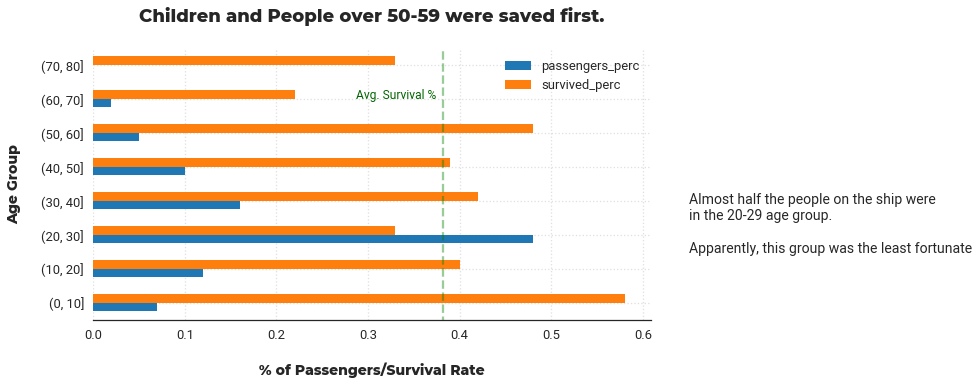

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

(pd.DataFrame({
    'age_group': pd.cut(df['age'], bins=range(0, 81, 10)),
    'survived': y
})
 .groupby('age_group')
 .apply(lambda g: (g.loc[:, 'survived'].mean(), g.shape[0]/float(df.shape[0])))
 .reset_index()
 .assign(survived_perc = lambda fr: fr.loc[:, 0].map(lambda i: i[0]),
         passengers_perc = lambda fr: fr.loc[:, 0].map(lambda i: i[1]))
 .drop([0], axis=1)
 .set_index('age_group')
 .round(2)
 .plot.barh(ax=ax)
)

ax.set_title("Children and People over 50-59 were saved first.\n", fontdict=font_title);
ax.set_xlabel("\n% of Passengers/Survival Rate", fontdict=font_axes)
ax.set_ylabel("Age Group\n", fontdict=font_axes)

ax.vlines(y.mean(), -1, 9, color='green', linestyle='dashed', alpha=0.4)
ax.annotate(s="Avg. Survival %", xy=(y.mean() - 0.095 , 6), color='darkgreen', fontsize=12)

ax.grid(True, linestyle=":", alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(0.65, 1, 
        """Almost half the people on the ship were \nin the 20-29 age group.
        \nApparently, this group was the least fortunate
        """, 
        fontdict=font_text)

plt.savefig("reports/figures/01-survival-by-age-group.png", bbox_inches='tight', pad_inches=0.5)
;

''

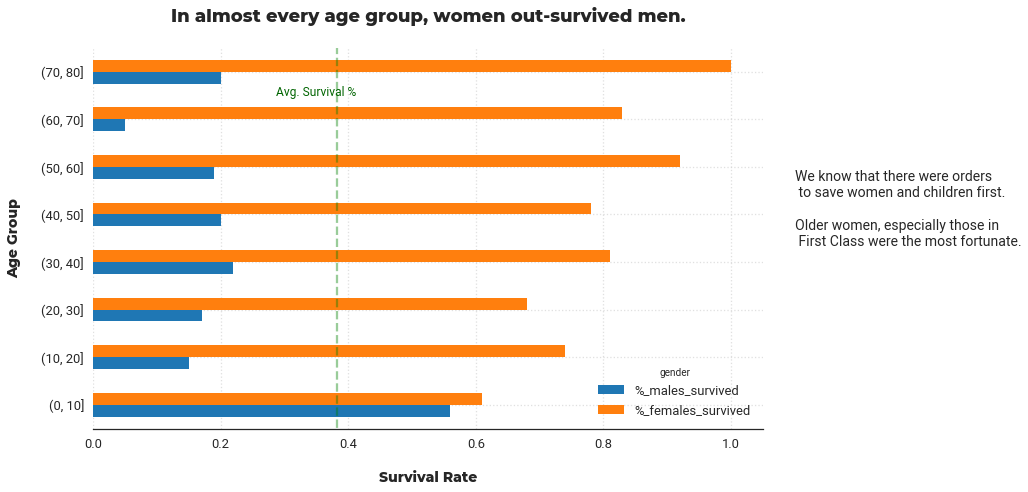

In [10]:
fig, ax = plt.subplots(figsize=(12, 7))

(pd.pivot_table(
    data=pd.DataFrame({
        'age_group': pd.cut(df['age'], bins=range(0, 81, 10)),
        'survived': y,
        'gender': df['gender']
    }), 
    index='age_group', 
    columns='gender', 
    values='survived', 
    aggfunc='mean'
).round(2).rename(columns={
    0: '%_males_survived',
    1: '%_females_survived'
})
).plot.barh(ax=ax)


ax.set_title("In almost every age group, women out-survived men.\n", fontdict=font_title);
ax.set_xlabel("\nSurvival Rate", fontdict=font_axes)
ax.set_ylabel("Age Group\n", fontdict=font_axes)

ax.vlines(y.mean(), -1, 9, color='green', linestyle='dashed', alpha=0.4)
ax.annotate(s="Avg. Survival %", xy=(y.mean() - 0.095 , 6.5), color='darkgreen', fontsize=12)

ax.grid(True, linestyle=":", alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(1.1, 3, 
        """We know that there were orders\n to save women and children first.
        \nOlder women, especially those in\n First Class were the most fortunate.
        """, 
        fontdict=font_text)

plt.savefig("reports/figures/01-survival-by-age-group-and-gender.png", bbox_inches='tight', pad_inches=0.5)
;

---

# Feature Selection

In [20]:
X = df.copy().drop(['survived'], axis=1)
y = df['survived'].copy()

from src.features.selection import find_important_variables

important_vars = \
find_important_variables(X=X, y=y)

important_vars.round(2).sort_values('avg_rank', ascending=False)

Importing Libraries...
There are 13 variables.
There are 0 Zero Variance Predictors. Ignoring these...
There are 0 Variables with over 90% missing data. Ignoring these...
Now there are 13 variables.
Scaling Data (filling missings with Zeros.)...
Finished.
Calculating % difference in means...
Finished.
Calculating f-scores and p-values...
Fitting default regression-based models and calculating standardized coefficients...
Fitting default tree-based models and finding feature importances...
Putting them all together...
9 variables have a p-value under 0.05
Returning variable importance ranks in a DataFrame...

Note that a higher Average Rank of Variables is better.

Here are the first few variables...
gender      10.7
fare         9.8
parch        8.2
pclass_2     7.8
pclass_1     7.7
Name: avg_rank, dtype: float64


,f_values,p_values,std_betas,svc_coefs,rafo_imps,xtree_imps,avg_rank
gender,483.25,0.00,1.22,0.47,0.29,0.24,10.67
fare,83.14,0.00,0.04,0.00,0.24,0.27,9.83
parch,8.99,0.00,-0.03,-0.01,0.05,0.04,8.17
pclass_2,3.38,0.07,0.10,0.03,0.02,0.02,7.83
pclass_1,110.71,0.00,0.28,0.10,0.00,0.03,7.67
age,2.51,0.11,-0.47,-0.16,0.23,0.25,6.67
embarked_C,44.84,0.00,-0.00,-0.07,0.01,0.02,6.50
sibsp,1.01,0.31,-0.33,-0.11,0.04,0.04,6.33
pclass_3,114.16,0.00,-0.32,-0.11,0.05,0.02,6.00
age__is_null,15.35,0.00,-0.10,-0.03,0.01,0.02,5.83
